In [12]:
import pandas as pd
import numpy as np
import gudhi as gd
from gudhi.weighted_rips_complex import WeightedRipsComplex
from gudhi.point_cloud.timedelay import TimeDelayEmbedding
from gudhi.point_cloud.dtm import DistanceToMeasure
from gudhi.hera import wasserstein_distance
from gudhi.representations import PersistenceImage, BettiCurve
from sklearn.decomposition import PCA
import umap
from gudhi.representations.metrics import WassersteinDistance
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.manifold import MDS
import os
from scipy import stats
from scipy.spatial.distance import cdist
from scipy.spatial.distance import pdist
from scipy import signal
from scipy.stats import levy_stable
from symulacja_py import impsim
#%matplotlib widget

In [13]:
def create_signal(alpha, impulse_amplitude):
    fs = 25000
    fmod = 30
    f_center = 5000
    bandwidth = 1500
    shift = 0

    amp_imp = impulse_amplitude
    alfa = alpha
    skala = 0.5

    varsize = 2*fs
    tt_ts = np.linspace(1/fs,varsize/fs,varsize)
    #szum = np.random.normal(0,skala,varsize) #szum Gaussowski
    szum = levy_stable.rvs(alfa,0,0,skala,varsize)  #szum alfa-stabilny

    signal_l = 9*impsim(fs,varsize,fmod,amp_imp,f_center,bandwidth,shift)+szum
    return signal_l

In [20]:
#generate data under null, i.e. only noise
alphas = np.linspace(1.1,2,19)

amplitude = 0
mc_iterations = 1000
avg_bcs = []
acc_threshs = []

for alpha in alphas:
    print("***************alpha=",alpha,"******************")
    print("=============generating data====================")
    data = []
    for i in range(mc_iterations):
        data.append(create_signal(alpha, amplitude))
    #dim * delay should roughly equal len(time_series)/numer_of_periods
    dim = 3*833#417# half period
    delay = len(data[0])//dim
    print("delay", delay)
    skip = 1#200#0#100
    print(dim*delay)
    print(len(data[0])/24)

    print("===============computing SWE====================")
    tde = TimeDelayEmbedding(dim = dim, delay=delay, skip=skip)
    point_clouds = tde.transform(data)

    for i in range(0,len(point_clouds)):
        point_clouds[i] = point_clouds[i]-np.mean(point_clouds[i],1)[:, None]
        point_clouds[i] = point_clouds[i]/np.sqrt(np.sum(point_clouds[i]**2, 1))[:, None]

    print(np.array(point_clouds).shape)
    print(len(point_clouds[0]))  
    print("=============computing Rips PH==================")
    pds = []
    weighted = True
    for pc in point_clouds:
        if weighted:
            dist = cdist(pc,pc)
            dtm = DistanceToMeasure(5, dim = 10, q=2, metric="precomputed")
            r = dtm.fit_transform(dist)
            ac = WeightedRipsComplex(distance_matrix=dist,weights = 1/r)
        else:
            ac = gd.RipsComplex(points=pc)

        st = ac.create_simplex_tree(max_dimension = 2)
        st.compute_persistence()
        pd = st.persistence_intervals_in_dimension(1)
        pds.append(pd)

    print("=============computing betti curves==============")

    start = min([np.min(d) for d in pds])-0.005
    end = max([np.max(d) for d in pds])+0.005
    print(start,end)
    start = 2.989
    end = 3.16
    x = np.linspace(start,end,1000)
    bc = BettiCurve(predefined_grid=x)
    betti_curves = bc.fit_transform(pds)
    avg_bc = np.mean(betti_curves, axis=0)
    avg_bcs.append(avg_bc)
    print("***************alpha=",alpha,"******************")
    print("=============generating data====================")
    data = []
    for i in range(mc_iterations):
        data.append(create_signal(alpha, amplitude))
    #dim * delay should roughly equal len(time_series)/numer_of_periods
    dim = 3*833#417# half period
    delay = len(data[0])//dim
    print("delay", delay)
    skip = 1#200#0#100
    print(dim*delay)
    print(len(data[0])/24)

    print("===============computing SWE====================")
    tde = TimeDelayEmbedding(dim = dim, delay=delay, skip=skip)
    point_clouds = tde.transform(data)

    for i in range(0,len(point_clouds)):
        point_clouds[i] = point_clouds[i]-np.mean(point_clouds[i],1)[:, None]
        point_clouds[i] = point_clouds[i]/np.sqrt(np.sum(point_clouds[i]**2, 1))[:, None]

    print(np.array(point_clouds).shape)
    print(len(point_clouds[0]))  
    print("=============computing Rips PH==================")
    pds = []
    weighted = True
    for pc in point_clouds:
        if weighted:
            dist = cdist(pc,pc)
            dtm = DistanceToMeasure(5, dim = 10, q=2, metric="precomputed")
            r = dtm.fit_transform(dist)
            ac = WeightedRipsComplex(distance_matrix=dist,weights = 1/r)
        else:
            ac = gd.RipsComplex(points=pc)

        st = ac.create_simplex_tree(max_dimension = 2)
        st.compute_persistence()
        pd = st.persistence_intervals_in_dimension(1)
        pds.append(pd)

    print("=============computing betti curves==============")

    start = min([np.min(d) for d in pds])-0.005
    end = max([np.max(d) for d in pds])+0.005
    print(start,end)
    start = 2.989
    end = 3.16
    x = np.linspace(start,end,1000)
    bc = BettiCurve(predefined_grid=x)
    betti_curves = bc.fit_transform(pds)
    acc_thresh = np.quantile(cdist([avg_bc],betti_curves, "chebyshev")[0],0.95)
    acc_threshs.append(acc_thresh)

***************alpha= 1.1 ******************
=============generating data====================
delay 20
49980
2083.3333333333335
===============computing SWE====================
(1000, 40, 2499)
40
=============computing Rips PH==================
=============computing betti curves==============
2.986974956083783 3.123721719725891
***************alpha= 1.1 ******************
=============generating data====================
delay 20
49980
2083.3333333333335
===============computing SWE====================
(1000, 40, 2499)
40
=============computing Rips PH==================
=============computing betti curves==============
2.9878397103443897 3.2903140361613135
***************alpha= 1.1500000000000001 ******************
=============generating data====================
delay 20
49980
2083.3333333333335
===============computing SWE====================
(1000, 40, 2499)
40
=============computing Rips PH==================
=============computing betti curves==============
2.989461368297979 3.129

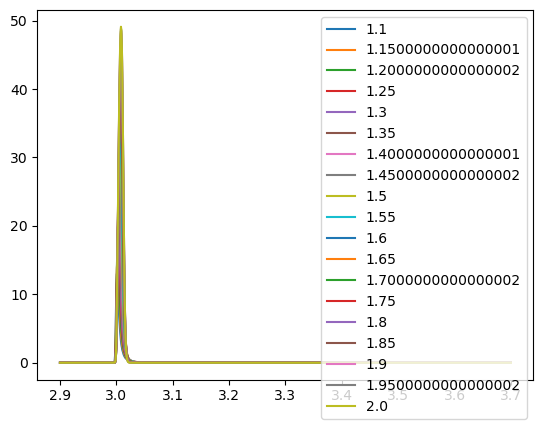

In [ ]:
f,ax = plt.subplots()
for i in range(0,len(alphas)):
    ax.plot(x,avg_bcs[i],label=alphas[i])

ax.legend()
plt.show()

In [ ]:
amplitudes = np.linspace(0,2,3)
test_powers_alpha = np.zeros((len(alphas),len(amplitudes)), dtype=float)

for k in range(0,len(alphas)):
    alpha = alphas[k]
    print("_______________________alpha=",alpha,"__________________________")
    #test_powers = np.zeros_like(amplitudes, dtype=float)
    
    for j in range(0,len(amplitudes)):
        a=amplitudes[j]
        print("******************",a,"*******************")
        print("=============generating data====================")
        data = []
        for i in range(mc_iterations):
            data.append(create_signal(alpha, a))
        #dim * delay should roughly equal len(time_series)/numer_of_periods
        dim = 3*833#417# half period
        delay = len(data[0])//dim
        print("delay", delay)
        skip = 1#200#0#100
        print(dim*delay)
        print(len(data[0])/24)

        print("===============computing SWE====================")
        tde = TimeDelayEmbedding(dim = dim, delay=delay, skip=skip)
        point_clouds = tde.transform(data)

        for i in range(0,len(point_clouds)):
            point_clouds[i] = point_clouds[i]-np.mean(point_clouds[i],1)[:, None]
            point_clouds[i] = point_clouds[i]/np.sqrt(np.sum(point_clouds[i]**2, 1))[:, None]

        print(np.array(point_clouds).shape)
        print(len(point_clouds[0]))  
        print("=============computing Rips PH==================")
        pds = []
        weighted = True
        for pc in point_clouds:
            if weighted:
                dist = cdist(pc,pc)
                dtm = DistanceToMeasure(5, dim = 10, q=2, metric="precomputed")
                r = dtm.fit_transform(dist)
                ac = WeightedRipsComplex(distance_matrix=dist,weights = 1/r)
            else:
                ac = gd.RipsComplex(points=pc)

            st = ac.create_simplex_tree(max_dimension = 2)
            st.compute_persistence()
            pd = st.persistence_intervals_in_dimension(1)
            pds.append(pd)

        print("=============computing betti curves==============")

        start = min([np.min(d) for d in pds])-0.005
        end = max([np.max(d) for d in pds])+0.005
        print(start,end)
        start = 2.989
        end = 3.16
        x = np.linspace(start,end,1000)
        bc = BettiCurve(predefined_grid=x)
        betti_curves = bc.fit_transform(pds)
        dists = cdist([avg_bcs[k]],betti_curves, "chebyshev")[0]
        power = np.sum(dists>acc_threshs[k])/mc_iterations
        test_powers_alpha[k][j] = power
        #test_powers[j] = power
        #j=j+1
    #test_powers_alpha.append(test_powers)

_______________________alpha= 1.1 __________________________
****************** 0.0 *******************
=============generating data====================
delay 20
49980
2083.3333333333335
===============computing SWE====================
(1000, 40, 2499)
40
=============computing Rips PH==================
=============computing betti curves==============
2.9870200443652224 3.1250562290111468
****************** 1.0 *******************
=============generating data====================
delay 20
49980
2083.3333333333335
===============computing SWE====================
(1000, 40, 2499)
40
=============computing Rips PH==================
=============computing betti curves==============
2.9860348079030286 3.1230333341073107
****************** 2.0 *******************
=============generating data====================
delay 20
49980
2083.3333333333335
===============computing SWE====================
(1000, 40, 2499)
40
=============computing Rips PH==================
=============computing betti cu

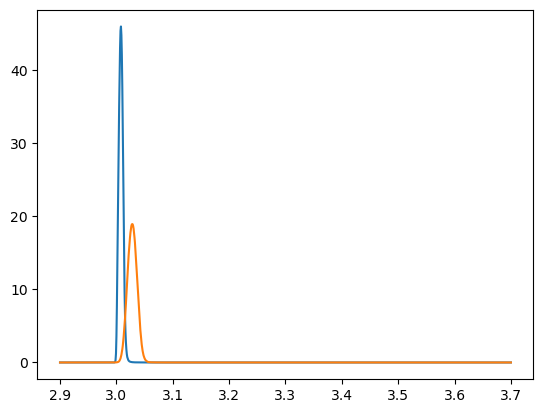

In [ ]:
f,ax = plt.subplots()
#ax.scatter(amplitudes, l1_power)
ax.plot(x,avg_bc)
ax.plot(x,np.mean(betti_curves,axis=0))
plt.show()

[0.048 0.039 0.054 0.055 0.052 0.045 0.045 0.049 0.042 0.066 0.06  0.034
 0.054 0.068 0.061 0.054 0.066 0.063 0.075 0.056 0.058]
[0.05  0.049 0.047 0.036 0.048 0.038 0.051 0.042 0.069 0.057 0.056 0.056
 0.062 0.071 0.049 0.059 0.06  0.052 0.066 0.066 0.078]
[0.049 0.062 0.063 0.065 0.05  0.057 0.06  0.069 0.066 0.051 0.063 0.062
 0.061 0.073 0.065 0.084 0.053 0.077 0.08  0.079 0.076]
[0.041 0.03  0.041 0.042 0.034 0.039 0.037 0.045 0.048 0.039 0.047 0.044
 0.042 0.06  0.037 0.052 0.048 0.069 0.057 0.076 0.083]
[0.057 0.068 0.053 0.049 0.053 0.061 0.061 0.058 0.064 0.06  0.058 0.063
 0.055 0.067 0.085 0.071 0.079 0.089 0.104 0.102 0.113]
[0.025 0.037 0.041 0.037 0.034 0.048 0.037 0.049 0.043 0.054 0.05  0.061
 0.064 0.072 0.109 0.123 0.111 0.144 0.169 0.185 0.262]
[0.051 0.049 0.045 0.046 0.052 0.061 0.06  0.061 0.059 0.069 0.083 0.106
 0.104 0.105 0.165 0.193 0.267 0.313 0.358 0.487 0.593]
[0.062 0.054 0.061 0.08  0.059 0.076 0.079 0.101 0.084 0.076 0.121 0.149
 0.205 0.278 0.352 0.46 

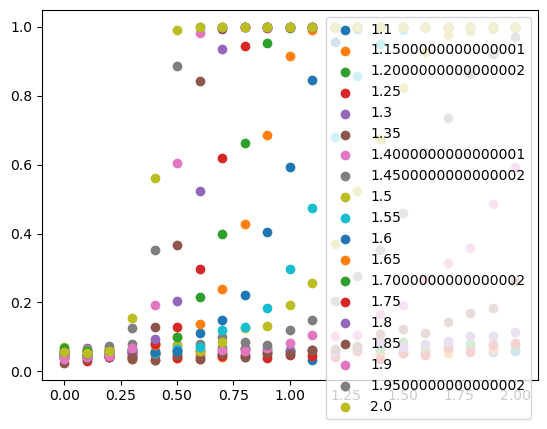

In [ ]:
f,ax = plt.subplots()
for i in range(0,len(alphas)):
    ax.scatter(amplitudes, test_powers_alpha[i], label=alphas[i])
    print(test_powers_alpha[i])
ax.legend()
plt.show()

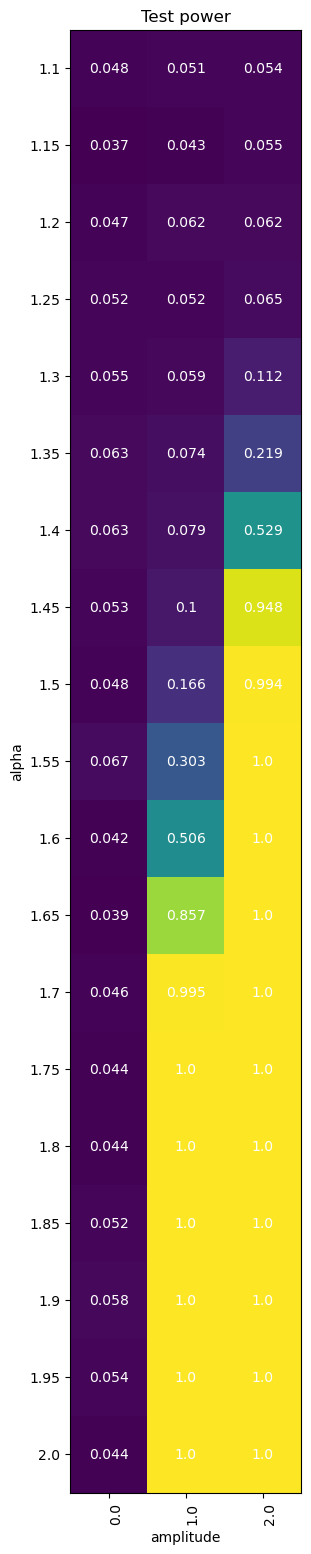

In [ ]:
f,ax = plt.subplots(figsize = (21,19))
ax.imshow(test_powers_alpha)

ax.set_xticks(range(0,len(amplitudes)), labels=np.round(amplitudes,1))
ax.set_yticks(range(0,len(alphas)), labels = np.round(alphas,2))

ax.set_xlabel("amplitude")
ax.set_ylabel("alpha")

plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(alphas)):
    for j in range(len(amplitudes)):
        text = ax.text(j, i, test_powers_alpha[i][j],
                       ha="center", va="center", color="w")


#ax.scatter(np.linspace(0,20,21), 19*(-1.1+(1.7/((0.1*np.linspace(0,20,21))**(0.2)))), color="red")
plt.title("Test power")
#plt.savefig("GoF-test-powers.pdf")
plt.show()

In [ ]:
#np.savetxt("test_powers_alpha1.1-2_amplitude0-2.txt",np.array(test_powers_alpha))
#print(np.log(2/1.7)/np.log(0.5))
#print(np.log(1.5/1.7)/np.log(2))#
#np.sum(cdist([avg_bcs[k]],betti_curves, "chebyshev")[0]>acc_thresh)/2000
print(power)
print(test_powers)
#print((1.7**5)*(alphas**(-5)))

0.0375
[0]


In [15]:
def compute_test_power(k,j):
    a=amplitudes[j]
    alpha = alphas[k]
    #print("******************",a,"*******************")
    #print("=============generating data====================")
    data = []
    for i in range(mc_iterations):
        data.append(create_signal(alpha, a))
    #dim * delay should roughly equal len(time_series)/numer_of_periods
    dim = 3*833#417# half period
    delay = len(data[0])//dim
    #print("delay", delay)
    skip = 1#200#0#100
    #print(dim*delay)
    #print(len(data[0])/24)

    #print("===============computing SWE====================")
    tde = TimeDelayEmbedding(dim = dim, delay=delay, skip=skip)
    point_clouds = tde.transform(data)

    for i in range(0,len(point_clouds)):
        point_clouds[i] = point_clouds[i]-np.mean(point_clouds[i],1)[:, None]
        point_clouds[i] = point_clouds[i]/np.sqrt(np.sum(point_clouds[i]**2, 1))[:, None]

    #print(np.array(point_clouds).shape)
    #print(len(point_clouds[0]))  
    #print("=============computing Rips PH==================")
    pds = []
    weighted = True
    for pc in point_clouds:
        if weighted:
            dist = cdist(pc,pc)
            dtm = DistanceToMeasure(5, dim = 10, q=2, metric="precomputed")
            r = dtm.fit_transform(dist)
            ac = WeightedRipsComplex(distance_matrix=dist,weights = 1/r)
        else:
            ac = gd.RipsComplex(points=pc)

        st = ac.create_simplex_tree(max_dimension = 2)
        st.compute_persistence()
        pd = st.persistence_intervals_in_dimension(1)
        pds.append(pd)

    #print("=============computing betti curves==============")

    start = min([np.min(d) for d in pds])-0.005
    end = max([np.max(d) for d in pds])+0.005
    #print(start,end)
    start = 2.989
    end = 3.16
    x = np.linspace(start,end,1000)
    bc = BettiCurve(predefined_grid=x)
    betti_curves = bc.fit_transform(pds)
    dists = cdist([avg_bcs[k]],betti_curves, "chebyshev")[0]
    power = np.sum(dists>acc_threshs[k])/mc_iterations
    test_powers_alpha[k][j] = power
    return power

In [21]:
from joblib import Parallel, delayed
results = Parallel(n_jobs=4)(delayed(compute_test_power)(k, j) for k in range(0,len(alphas)) for j in range(0,len(amplitudes)))
#results = [compute_test_power(k, j) for k in range(0,len(alphas)) for j in range(0,len(amplitudes))]

In [23]:
np.array(results)

array([0.052, 0.051, 0.063, 0.051, 0.053, 0.073, 0.053, 0.066, 0.085,
       0.052, 0.053, 0.084, 0.046, 0.061, 0.118, 0.04 , 0.054, 0.132,
       0.057, 0.087, 0.57 , 0.05 , 0.094, 0.915, 0.074, 0.212, 0.999,
       0.06 , 0.342, 1.   , 0.05 , 0.564, 1.   , 0.054, 0.902, 1.   ,
       0.051, 0.998, 1.   , 0.045, 1.   , 1.   , 0.051, 1.   , 1.   ,
       0.056, 1.   , 1.   , 0.037, 1.   , 1.   , 0.055, 1.   , 1.   ,
       0.05 , 1.   , 1.   ])

In [ ]:
print(alphas)
print(amplitudes)

test_powers_alpha

[1.1  1.15 1.2  1.25 1.3  1.35 1.4  1.45 1.5  1.55 1.6  1.65 1.7  1.75
 1.8  1.85 1.9  1.95 2.  ]
[0. 1. 2.]


array([0., 0.])